In [1]:
%tensorflow_version 1.x

!pip install mne

import tensorflow as tf
tf.enable_eager_execution()

import os
import numpy as np
import pandas as pd
import mne
import csv, json
import datetime
import matplotlib.pyplot as plt
import sklearn
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [0]:
def undersample(X, new_freq = 50, current_freq = 500, verbose = False):
    if current_freq % new_freq > 0: 
        print('(current_freq / new_frequency) should be an integer')
        return 0
    ratio = new_freq / current_freq
    num_points = int(X.shape[1] * ratio)
    indices = np.arange(start = 0, stop = X.shape[1], step = int(ratio**-1))
    X_new = X[:,indices,:]
    if verbose: 
        print('Old dimensions:',X.shape)
        print('New dimensions:',X_new.shape)
    return X_new

def edf_to_raw_dataset(edf_path, scores_path):
    edf = mne.io.read_raw_edf(edf_path)
    sampling_rate = int(edf.info['sfreq'])
    name = datetime.datetime.utcfromtimestamp(edf.info['meas_date'][0]).strftime('%Y-%m-%d %H:%M:%S')
    
    header = (','.join(edf.ch_names)).split(',')
    df = edf.get_data().T
    
    scores = np.squeeze( pd.read_excel(scores_path, keep_default_na=False).values )
    values_per_window = int(df.shape[0]/scores.shape[0])
    num_windows = scores.shape[0]
    
    df = df[:num_windows*values_per_window]
    df = np.reshape(df, newshape=(num_windows, values_per_window, 2))

    scores[scores=='D'] = 'WA'
    scores[scores=='SS'] = 'WA'
    
    scores[scores=='NA'] = 'NR'
    scores[scores=='WA'] = 'W'
    scores[scores=='RA'] = 'R'

#     to_drop = (scores=='NA') | (scores=='WA') | (scores=='RA')
    # print(df.shape, scores.shape)
#     df = df[~to_drop]
#     scores = scores[~to_drop]
    # print(df.shape, scores.shape)

    
    return df, scores

def edf_to_dataset(edf_path, scores_path):
    edf = mne.io.read_raw_edf(edf_path)
    sampling_rate = int(edf.info['sfreq'])
    name = datetime.datetime.utcfromtimestamp(edf.info['meas_date'][0]).strftime('%Y-%m-%d %H:%M:%S')
    
    header = (','.join(edf.ch_names)).split(',')
    df = edf.get_data().T
    
    scores = np.squeeze( pd.read_excel(scores_path, keep_default_na=False).values )
    values_per_window = int(df.shape[0]/scores.shape[0])
    num_windows = scores.shape[0]
    
    df = df[:num_windows*values_per_window]
    df = np.reshape(df, newshape=(num_windows, values_per_window, 2))

    scores[scores=='D'] = 'WA'
    scores[scores=='SS'] = 'WA'
    
    # scores[scores=='NA'] = 'NR'
    # scores[scores=='WA'] = 'W'
    # scores[scores=='RA'] = 'R'

    to_drop = (scores=='NA') | (scores=='WA') | (scores=='RA')
    # print(df.shape, scores.shape)
    df = df[~to_drop]
    scores = scores[~to_drop]
    # print(df.shape, scores.shape)

    
    return df, scores

def edfs_to_dataset(folder, undersample_freq = 500):
    dataset_names = []
    for filename in sorted(os.listdir(folder), key=lambda x: int(x.split('_')[0][3:]) ):
        name = filename.split('.')[0].replace('-', '_')
        if name not in dataset_names: dataset_names.append(name)
    print(dataset_names)

    for dataset in dataset_names:
        edf_path = folder + '/' + dataset + '.edf'
        excel_path = folder + '/' + dataset + '.xls'
        X, Y = edf_to_dataset(edf_path, excel_path)
        if undersample_freq < 500:
            X = undersample(X, new_freq=undersample_freq)
        yield X, Y

def merge_datasets(list_X, list_Y):
    X_merged, Y_merged = None, None
    for i in range(len(list_X)):
        X = list_X[i]
        Y = list_Y[i]
        # print(X.shape)
        # print(Y.shape)
        X_merged = X if X_merged is None else np.vstack([X_merged, X])
        Y_merged = Y if Y_merged is None else np.hstack([Y_merged, Y])
        
    # print(X_merged.shape)
    # print(Y_merged.shape)
    return X_merged, Y_merged

def labels_to_onehot(Y, categories = {}):
#     print(Y)
    Y = Y.copy()
    count = 0
    for i in range(len(Y)):
        value = Y[i]
        if not value in categories:
            categories[value] = count
            count += 1
        Y[i] = categories[value]

    Y = Y.astype(int)
    Y_onehot = np.zeros((Y.shape[0], len(categories)))
    Y_onehot[np.arange(Y.shape[0]), Y] = 1

#     print(Y_onehot)
    
    return Y_onehot, categories


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!rm -r /content/VEH\ Tx\ \(N=10\)
!cp /content/drive/My\ Drive/VEH-Tx.zip ./
!unzip ./VEH-Tx.zip -d ./
os.rename('./VEH Tx (N=10)/Veh72-02142015.xls', './VEH Tx (N=10)/Veh72_02142015.xls')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
rm: cannot remove '/content/VEH Tx (N=10)': No such file or directory
Archive:  ./VEH-Tx.zip
   creating: ./VEH Tx (N=10)/
 extracting: ./VEH Tx (N=10)/Veh72-02142015.xls  
 extracting: ./VEH Tx (N=10)/Veh93_02272015.xls  
 extracting: ./VEH Tx (N=10)/Veh70_02202015.edf  
 extracting: ./VEH Tx (N=10)/Veh74_02032015.xls  
 extracting: ./VEH Tx (N=10)/Veh70_02202015.xls  
 extracting: ./VEH Tx (N=10)/Veh72_02142015.edf  
 extracting: ./VEH Tx (N=10)/Veh74_020320

In [3]:
datasets_folder = './VEH Tx (N=10)'
categories = {}
datasets_X, datasets_Y = [], []
for X,Y in edfs_to_dataset(datasets_folder):
    datasets_X.append(X)
    datasets_Y.append(Y)

['Veh70_02202015', 'Veh72_02142015', 'Veh74_02032015', 'Veh93_02272015', 'Veh116_01292016', 'Veh118_01182016', 'Veh120_01112016', 'Veh122_01072016', 'Veh124_01052016', 'Veh128_01182016']
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh70_02202015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh72_02142015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh74_02032015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh93_02272015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh116_01292016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF pa

In [72]:
X_train, Y_train = merge_datasets(datasets_X[5:], datasets_Y[5:])
X_val, Y_val = merge_datasets(datasets_X[0:5], datasets_Y[0:5])

unique, counts = np.unique(Y_train, return_counts=True)
print('Training samples:')
print(dict(zip(unique, counts)))

unique, counts = np.unique(Y_val, return_counts=True)
print('\nValidation samples:')
print(dict(zip(unique, counts)))

Y_train, categories = labels_to_onehot(Y_train, {})
Y_val, categories = labels_to_onehot(Y_val, {})

print('\n\nTraining shape (X, Y):', X_train.shape, Y_train.shape)
print('Validation shape (X, Y):', X_val.shape, Y_val.shape)
print(categories)

Training samples:
{'NR': 4930, 'R': 592, 'W': 2012}

Validation samples:
{'NR': 4678, 'R': 433, 'W': 1886}


Training shape (X, Y): (7534, 5000, 2) (7534, 3)
Validation shape (X, Y): (6997, 5000, 2) (6997, 3)
{'W': 0, 'NR': 1, 'R': 2}


In [0]:
# import tensorflow.keras as keras

# class CNN_Scorer(keras.Sequential):

#     def __init__(self, num_classes=6, filters=[10, 10], kernel_size=4, max_pool_size=2, use_batch_normalization=False, embedding_dimension=1000, dropout=0.4):
#         super(CNN_Scorer, self).__init__(name='CNN')
#         self.pipeline = []
        
#         for num_filters in filters:
#             self.pipeline.append( keras.layers.Conv1D(num_filters, kernel_size, activation='relu') )
#             if use_batch_normalization: self.pipeline.append( keras.layers.BatchNormalization() )
#             self.pipeline.append( keras.layers.MaxPool1D(max_pool_size) )
            
#         self.pipeline.append( keras.layers.Flatten() )

#         if embedding_dimension > 0:
#             self.pipeline.append( keras.layers.Dense(embedding_dimension, activation='relu') )
#             if dropout > 0: self.pipeline.append( keras.layers.Dropout(dropout) )

#         self.pipeline.append( keras.layers.Dense(num_classes, activation='softmax') )

#     def call(self, x):
#         for layer in self.pipeline:
#             # print(x.shape)
#             x = layer(x)
#         return x
    

In [104]:
# model = CNN_Scorer(num_classes=len(categories), filters=[5, 5, 5, 5, 5, 5], use_batch_normalization=True, embedding_dimension=0, dropout=0.4)



num_classes=len(categories)
filters=[20, 40, 60, 80, 100, 100]
kernel_size=4
max_pool_size=2
use_batch_normalization=True
embedding_dimension=0
dropout=0.4

first_layer = True
model = keras.Sequential()
for num_filters in filters:
    if first_layer:
        model.add( keras.layers.Conv1D(num_filters, kernel_size, activation='relu', input_shape=X_train[0].shape) )
        first_layer = False
    else:
        model.add( keras.layers.Conv1D(num_filters, kernel_size, activation='relu') )
    if use_batch_normalization: model.add( keras.layers.BatchNormalization() )
    model.add( keras.layers.MaxPool1D(max_pool_size) )

model.add( keras.layers.Flatten() )

if embedding_dimension > 0:
    model.add( keras.layers.Dense(embedding_dimension, activation='relu') )
    if dropout > 0: model.add( keras.layers.Dropout(dropout) )

model.add( keras.layers.Dense(num_classes, activation='softmax') )




model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build()
model.summary()
# Y_hat = model.predict(X)

# model.evaluate(X, Y_onehot)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 4997, 20)          180       
_________________________________________________________________
batch_normalization_42 (Batc (None, 4997, 20)          80        
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 2498, 20)          0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 2495, 40)          3240      
_________________________________________________________________
batch_normalization_43 (Batc (None, 2495, 40)          160       
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 1247, 40)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 1244, 60)         

In [105]:
print(model.evaluate(X_val, Y_val))
mcp_save = ModelCheckpoint('./best_current.hdf5', save_best_only=True, monitor='val_acc', mode='max')
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), callbacks=[mcp_save], epochs=40)

6997/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

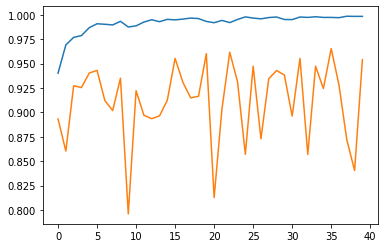

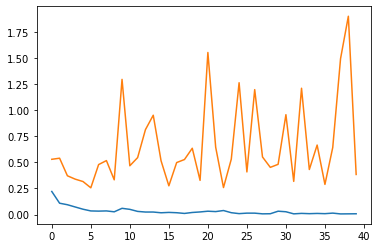

Maximum acc on training: 0.99840724 at epoch: 38
Maximum acc on validation: 0.9652708 at epoch: 36
6997/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [106]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print('Maximum acc on training:', np.max(history.history['acc']),'at epoch:', np.argmax(history.history['acc'])+1)
print('Maximum acc on validation:', np.max(history.history['val_acc']),'at epoch:', np.argmax(history.history['val_acc'])+1)

model = load_model('./best_current.hdf5')
best_val_acc = model.evaluate(X_val, Y_val)[1]
print('Val score of best saved model:', best_val_acc)

In [107]:
from sklearn.metrics import confusion_matrix

predicted_classes = model.predict_classes(X_val)
Y_val_classes = np.argmax(Y_val, axis=1)


print('Total accuracy:', best_val_acc)
print('\nConfusion matrix:')
conf_mat = confusion_matrix(Y_val_classes, predicted_classes).T
print(conf_mat)
print(categories)

correct_classes = np.diag(conf_mat)
samples_per_class = conf_mat.sum(axis=0)
print('\nSamples per class:', samples_per_class)
print('Accuracy per class:', correct_classes*100/samples_per_class)

print('\nConfussion matrix accuracy per class GT (column accuracy/"recall"):')
print(conf_mat*100/samples_per_class)

samples_per_prediction = conf_mat.sum(axis=1)
print('\nConfussion matrix accuracy per prediction (row accuracy/"precision"):')
print( (conf_mat.T*100/samples_per_prediction).T )


Total accuracy: 0.9652708

Confusion matrix:
[[1804   66   19]
 [  33 4578   42]
 [  49   34  372]]
{'W': 0, 'NR': 1, 'R': 2}

Samples per class: [1886 4678  433]
Accuracy per class: [95.65217391 97.86233433 85.91224018]

Confussion matrix accuracy per class GT (column accuracy/"recall"):
[[95.65217391  1.41085934  4.38799076]
 [ 1.74973489 97.86233433  9.69976905]
 [ 2.5980912   0.72680633 85.91224018]]

Confussion matrix accuracy per prediction (row accuracy/"precision"):
[[95.50026469  3.49391212  1.00582319]
 [ 0.70921986 98.38813669  0.90264346]
 [10.76923077  7.47252747 81.75824176]]


# PREDICTIONS TO CSV

In [108]:
predicting_dataset = 'Veh70_02202015'


edf_to_predict = datasets_folder + '/' + predicting_dataset + '.edf'
excel_path_to_predict = datasets_folder + '/' + predicting_dataset + '.xls'

X_to_pred, Y_to_pred = edf_to_raw_dataset(edf_to_predict, excel_path_to_predict)
Y_to_pred, categories = labels_to_onehot(Y_to_pred, categories)

print(X_to_pred.shape, Y_to_pred.shape)
print('Accuracy on predicting dataset:', model.evaluate(X_to_pred, Y_to_pred)[1])

int_to_score = {v: k for k, v in categories.items()}
predictions = model.predict_classes(X_to_pred)
predictions = np.vectorize(int_to_score.get)(predictions)
print(predictions)
df = pd.DataFrame(data=predictions, columns=['Score'])
print(df.head())
df.to_csv('./predictions-'+predicting_dataset+'.xls', index=None)

Extracting EDF parameters from /content/VEH Tx (N=10)/Veh70_02202015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(2160, 5000, 2) (2160, 3)
2160/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# EXPORTING MODEL

In [0]:
model.save('1CNN-H5Model.h5')

In [0]:
# !pip install tensorflowjs
# import tensorflowjs as tfjs

# tfjs.converters.save_keras_model(model, './1CNN-Model')

In [0]:
!tensorflowjs_converter --input_format keras \
                       ./1CNN-H5Model.h5 \
                       ./1CNN-Model

In [103]:
!zip -r 1CNN-Model.zip 1CNN-Model

  adding: 1CNN-Model/ (stored 0%)
  adding: 1CNN-Model/group1-shard1of1.bin (deflated 8%)
  adding: 1CNN-Model/model.json (deflated 91%)
